In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [1]:
! pip cache purge

Files removed: 169


## Neural Network on PCA Results

In [10]:
# Directory where PCA results are saved
pca_dir = "../../data/pca_data/byBasin_pca"
result_dir = "../../data/performance_comparison"

# Output directories for plots and predictions
plot_dir = "../../images/neural_network_plots/neural_network_withPCA"
predicted_data_dir = "../../data/predicted_data/neural_network_withPCA"
os.makedirs(plot_dir, exist_ok=True)
os.makedirs(predicted_data_dir, exist_ok=True)

# Get a list of all PCA result files
pca_files = [f for f in os.listdir(pca_dir) if f.endswith('_pca_with_target.csv')]

# Dictionary to store results for each basin
results = {}

# Process each PCA result file
for file in pca_files:
    basin_name = file.replace('_pca_with_target.csv', '').replace(' ', '_')  # Replace spaces with underscores
    sanitized_basin_name = basin_name.replace(' ', '_')  # Sanitize basin name for file paths
    pca_df = pd.read_csv(f"{pca_dir}/{file}")

    # Separate data with known and unknown 'Li' values
    known_data = pca_df.dropna(subset=['Li'])
    unknown_data = pca_df[pca_df['Li'].isnull()]

    # Prepare training and testing data from known data
    principal_components = [f'PC{i+1}' for i in range(10)]  # Use the first 10 principal components
    X_known = known_data[principal_components]
    y_known = known_data['Li']
    X_train, X_test, y_train, y_test = train_test_split(X_known, y_known, test_size=0.2, random_state=42)

    # Initialize and train the neural network
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    # Predict and evaluate on known test data
    y_pred = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    explained_variance = explained_variance_score(y_test, y_pred)

    # Store results for known data evaluation
    results[basin_name] = {'MSE': mse, 'R2': r2, 'MAE': mae, 'RMSE': rmse, 'Explained Variance': explained_variance}
    print(f"Basin: {sanitized_basin_name} - MSE: {mse}, R2: {r2}, MAE: {mae}, RMSE: {rmse}, Explained Variance: {explained_variance}")

    # Plot actual vs predicted and save the plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Line for perfect prediction
    percentage_ranges = [5, 15, 25, 50]
    colors = ['lightblue', 'lightgreen', 'palegoldenrod', 'lightsalmon']
    for i, percentage in enumerate(percentage_ranges):
        threshold = (percentage / 100) * np.mean(y_test)
        plt.plot([y_test.min(), y_test.max()], [y_test.min() + threshold, y_test.max() + threshold],
                 linestyle='--', color=colors[i], label=f'Within {percentage}%')
        plt.plot([y_test.min(), y_test.max()], [y_test.min() - threshold, y_test.max() - threshold],
                 linestyle='--', color=colors[i])
    plt.ylim(bottom=0)
    plt.xlim(left=0)
    plt.xlabel('Actual Li Concentrations')
    plt.ylabel('Predicted Li Concentrations')
    plt.title(f'Actual vs. Predicted for {sanitized_basin_name}')
    plt.legend()
    plot_path = os.path.join(plot_dir, f"{sanitized_basin_name}_actual_predicted_neural_network_pca.png")
    plt.savefig(plot_path)
    plt.close()

    # Predict unknown 'Li' values if there are any
    if not unknown_data.empty:
        X_unknown = unknown_data[principal_components]
        y_unknown_pred = model.predict(X_unknown).flatten()
        unknown_data['Predicted_Li'] = y_unknown_pred

        pca_df.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred

        # Save predicted data for unknown values
        predicted_data_path = os.path.join(predicted_data_dir, f"{sanitized_basin_name}_predicted_Li_neural_network_pca.csv")
        pca_df.to_csv(predicted_data_path, index=False)

        # Plot predictions for unknown data and save the plot
        plt.figure(figsize=(6, 6))
        plt.hist(y_unknown_pred, bins=30, alpha=0.75)
        plt.xlabel('Predicted Lithium Concentration')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of Predicted Lithium Concentrations for New Samples in {sanitized_basin_name}')
        plot_hist_path = os.path.join(plot_dir, f"{sanitized_basin_name}_neural_network_predicted_distribution.png")
        plt.savefig(plot_hist_path)
        plt.close()

# Convert results to a DataFrame for better visualization or further analysis
nn_results_df_with_pca = pd.DataFrame(results).T
nn_results_df_with_pca.to_csv(os.path.join(result_dir, "neural_network_performance_PCA.csv"), index_label='Basin')

print("Saved performance metrics with PCA to CSV.")

c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Basin: Anadarko - MSE: 1942.4290894290473, R2: 0.8048807870364809, MAE: 16.538379051168008, RMSE: 44.07299728211195, Explained Variance: 0.8050550627265392
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\3342145403.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Basin: Appalachian - MSE: 1453.9788166749884, R2: 0.6020451022536689, MAE: 26.660209786655336, RMSE: 38.13107416104336, Explained Variance: 0.6257174546460079
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step


C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\3342145403.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Basin: Fort_Worth - MSE: 81.40698549092339, R2: 0.9335743297169957, MAE: 5.523589144945145, RMSE: 9.02258197474112, Explained Variance: 0.9460742989213968
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\3342145403.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Basin: Great_Plains - MSE: 39053.681124857976, R2: -0.04681281664418724, MAE: 56.55684562059549, RMSE: 197.62004231569725, Explained Variance: 0.03465177060992153
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step


C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\3342145403.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Basin: Gulf_Coast - MSE: 995.1542781917831, R2: 0.8240635349737486, MAE: 16.93539257562318, RMSE: 31.546065970129828, Explained Variance: 0.8307273730918241
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step


C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\3342145403.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Basin: Illinois - MSE: 98.62325699541944, R2: 0.48418794326144177, MAE: 6.643111930847168, RMSE: 9.930924276995542, Explained Variance: 0.49947404941035456
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step


C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\3342145403.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Basin: Michigan - MSE: 149.38479226523685, R2: 0.6262814845181941, MAE: 8.23496678940455, RMSE: 12.222307158030224, Explained Variance: 0.6263494862169368
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step


C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\3342145403.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Basin: Oklahoma_Platform - MSE: 173.17437698556844, R2: 0.4487130156173734, MAE: 8.84478149839476, RMSE: 13.159573586768245, Explained Variance: 0.45844298054843946
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step


C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\3342145403.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Basin: Pacific - MSE: 4.2657561151045735, R2: 0.588059242703808, MAE: 1.1871317040098128, RMSE: 2.06537069677687, Explained Variance: 0.6148504456105417
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step


C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\3342145403.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Basin: Permian - MSE: 4574.530932747289, R2: 0.10041768309085308, MAE: 15.185798825732212, RMSE: 67.63527875855387, Explained Variance: 0.11216172146185055
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step


C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\3342145403.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Basin: Rocky_Mountain - MSE: 36.55358302804796, R2: 0.8296002451552306, MAE: 3.2525747632980346, RMSE: 6.045955923429145, Explained Variance: 0.8299807624176799
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step


C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\3342145403.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Basin: Williston - MSE: 370.545219081834, R2: 0.8392349125157169, MAE: 12.604015512198425, RMSE: 19.24955113974957, Explained Variance: 0.8393153489583489
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step


C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\3342145403.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred


Saved performance metrics with PCA to CSV.


### Neural Network on Imputed Data without PCA

In [7]:
# Load the dataset with all basins
df = pd.read_csv("../../data/df_output/df_cleaned_imputed.csv")


# Output directories for plots and predictions
plot_dir = "../../images/neural_network_plots/neural_network_withoutPCA"
predicted_data_dir = "../../data/predicted_data/neural_network_withoutPCA"
result_dir="../../data/performance_comparison"
os.makedirs(plot_dir, exist_ok=True)
os.makedirs(predicted_data_dir, exist_ok=True)

# Define features to use for predicting 'Li'
predictors = ['B', 'Ba', 'Br', 'HCO3', 'FeTot', 'K', 'Na', 'Cl', 'SO4', 'Mg', 'Ca', 'Sr', 'Zn', 'TDS', 'DEPTHUPPER']

# Dictionary to store results for each basin
results = {}

# Loop through each unique basin category
for basin in df['BASIN_CATEGORY'].unique():
    sanitized_basin = basin.replace(' ', '_')  # Replace spaces with underscores
    print(f"Processing Gradient Boosting for {basin}")
    df_basin = df[df['BASIN_CATEGORY'] == basin]

    # Separate data with known and unknown 'Li' values
    known_data = df_basin.dropna(subset=['Li'])
    unknown_data = df_basin[df_basin['Li'].isnull()]

    # Prepare training and testing data from known data
    X_known = known_data[predictors]
    y_known = known_data['Li']
    X_train, X_test, y_train, y_test = train_test_split(X_known, y_known, test_size=0.2, random_state=42)

    # Initialize and train the neural network
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    # Predict and evaluate on known test data
    y_pred = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    explained_variance = explained_variance_score(y_test, y_pred)

    # Store results for known data evaluation
    results[basin] = {
        'MSE': mse,
        'R2': r2,
        'MAE': mae,
        'RMSE': rmse,
        'Explained Variance': explained_variance
    }
    print(f"Basin: {basin} - MSE: {mse}, R2: {r2}, MAE: {mae}, RMSE: {rmse}, Explained Variance: {explained_variance}")

    # Plot actual vs predicted and save the plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    percentage_ranges = [5, 15, 25, 50]
    colors = ['lightblue', 'lightgreen', 'palegoldenrod', 'lightsalmon']
    for i, percentage in enumerate(percentage_ranges):
        threshold = (percentage / 100) * np.mean(y_test)
        plt.plot([y_test.min(), y_test.max()], [y_test.min() + threshold, y_test.max() + threshold],
                 linestyle='--', color=colors[i], label=f'Within {percentage}%')
        plt.plot([y_test.min(), y_test.max()], [y_test.min() - threshold, y_test.max() - threshold],
                 linestyle='--', color=colors[i])
    plt.ylim(bottom=0)
    plt.xlim(left=0)
    plt.xlabel('Actual Li Concentrations')
    plt.ylabel('Predicted Li Concentrations')
    plt.title(f'Actual vs. Predicted for {basin}')
    plt.legend()
    plot_path = os.path.join(plot_dir, f"{sanitized_basin}_actual_predicted_neural_network_no_pca.png")
    plt.savefig(plot_path)
    plt.close()


    # Predict unknown 'Li' values if there are any
    if not unknown_data.empty:
        X_unknown = unknown_data[predictors]
        y_unknown_pred = model.predict(X_unknown).flatten()
        unknown_data['Predicted_Li'] = y_unknown_pred

        # Merge the predictions back to the main DataFrame
        df_basin.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred

        # Optional: to also show original 'Li' in the same column where available
        df_basin.loc[known_data.index, 'Predicted_Li'] = known_data['Li']

        # Save the full basin DataFrame including both known 'Li' and predicted 'Li' values
        predicted_data_path = os.path.join(predicted_data_dir, f"{sanitized_basin}_predicted_Li_neural_network_no_pca.csv")
        df_basin.to_csv(predicted_data_path, index=False)


        # Plot predictions for unknown data and save the plot
        plt.figure(figsize=(6, 6))
        plt.hist(y_unknown_pred, bins=30, alpha=0.75)
        plt.xlabel('Predicted Lithium Concentration')
        plt.ylabel('Frequency')
        plt.title(f'Distribution of Predicted Lithium Concentrations for New Samples in {basin}')
        plot_hist_path = os.path.join(plot_dir, f"{sanitized_basin}_predicted_distribution_neural_network_no_pca.png")
        plt.savefig(plot_hist_path)
        plt.close()

# Convert results to a DataFrame for better visualization or further analysis
nn_results_df_without_pca = pd.DataFrame(results).T
nn_results_df_without_pca.to_csv(os.path.join(result_dir, "neural_network_performance_no_pca.csv"), index_label='Basin')

print("Saved performance metrics without PCA to CSV.")

Processing Gradient Boosting for Appalachian


c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Basin: Appalachian - MSE: 16734.965643410484, R2: -3.580370405011517, MAE: 65.82904724994688, RMSE: 129.36369522942084, Explained Variance: -3.4285643588260433
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step
Processing Gradient Boosting for Permian


C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\2610839538.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\2610839538.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basin.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Basin: Permian - MSE: 8977.402642623892, R2: -0.7654078172836429, MAE: 42.65308503367084, RMSE: 94.74915642170062, Explained Variance: -0.7638843839828855
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step


C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\2610839538.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\2610839538.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basin.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred


Processing Gradient Boosting for Oklahoma Platform


c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Basin: Oklahoma Platform - MSE: 17486.286257261192, R2: -54.66621452098678, MAE: 63.31300393988105, RMSE: 132.23572231912672, Explained Variance: -54.36978452235416
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step


C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\2610839538.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\2610839538.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basin.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred


Processing Gradient Boosting for Gulf Coast


c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Basin: Gulf Coast - MSE: 12279.343059004803, R2: -1.1709038065649535, MAE: 82.90736059029695, RMSE: 110.81219724833906, Explained Variance: -0.015732269359868045
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step


C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\2610839538.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\2610839538.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basin.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred


Processing Gradient Boosting for Williston


c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Basin: Williston - MSE: 14103.035684817667, R2: -5.118755954487045, MAE: 99.74712016828926, RMSE: 118.75620272144806, Explained Variance: -1.242016609482485
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step


C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\2610839538.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\2610839538.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basin.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred


Processing Gradient Boosting for Michigan


c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Basin: Michigan - MSE: 88825.74541401307, R2: -221.21690179646725, MAE: 168.80103643115362, RMSE: 298.03648336070046, Explained Variance: -203.65090034859185
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
Processing Gradient Boosting for Pacific


C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\2610839538.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\2610839538.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basin.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Basin: Pacific - MSE: 1698.7790217135814, R2: -163.04977167017938, MAE: 26.15837610244751, RMSE: 41.21624706003182, Explained Variance: -160.2125524232726
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step
Processing Gradient Boosting for Illinois


C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\2610839538.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\2610839538.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basin.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Basin: Illinois - MSE: 13917.154375875154, R2: -71.78847040005586, MAE: 94.09639982795716, RMSE: 117.97098955198754, Explained Variance: -57.69097885333728
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step
Processing Gradient Boosting for Great Plains


C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\2610839538.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\2610839538.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basin.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Basin: Great Plains - MSE: 100414.60429629777, R2: -1.6915592007717875, MAE: 124.00871604259198, RMSE: 316.88263489231747, Explained Variance: -1.5482972856537751
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step
Processing Gradient Boosting for Anadarko


C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\2610839538.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\2610839538.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basin.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Basin: Anadarko - MSE: 15578.192352500017, R2: -0.5648471533689652, MAE: 102.7832270269574, RMSE: 124.81262897840112, Explained Variance: 0.12310495284554923
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step


C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\2610839538.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\2610839538.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basin.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using

Processing Gradient Boosting for Rocky Mountain
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Basin: Rocky Mountain - MSE: 3421.637231856377, R2: -14.950451287598387, MAE: 34.782855804043706, RMSE: 58.49476243097648, Explained Variance: -12.614290656491976
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step


C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\2610839538.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\2610839538.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basin.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred
c:\Users\darvarir\Anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using

Processing Gradient Boosting for Fort Worth
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Basin: Fort Worth - MSE: 373360.68426947785, R2: -303.6511741020848, MAE: 468.5259764099121, RMSE: 611.0324739892945, Explained Variance: -297.4089443795266
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step
Saved performance metrics without PCA to CSV.


C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\2610839538.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data['Predicted_Li'] = y_unknown_pred
C:\Users\darvarir\AppData\Local\Temp\ipykernel_47024\2610839538.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basin.loc[unknown_data.index, 'Predicted_Li'] = y_unknown_pred


## Performance Comparison

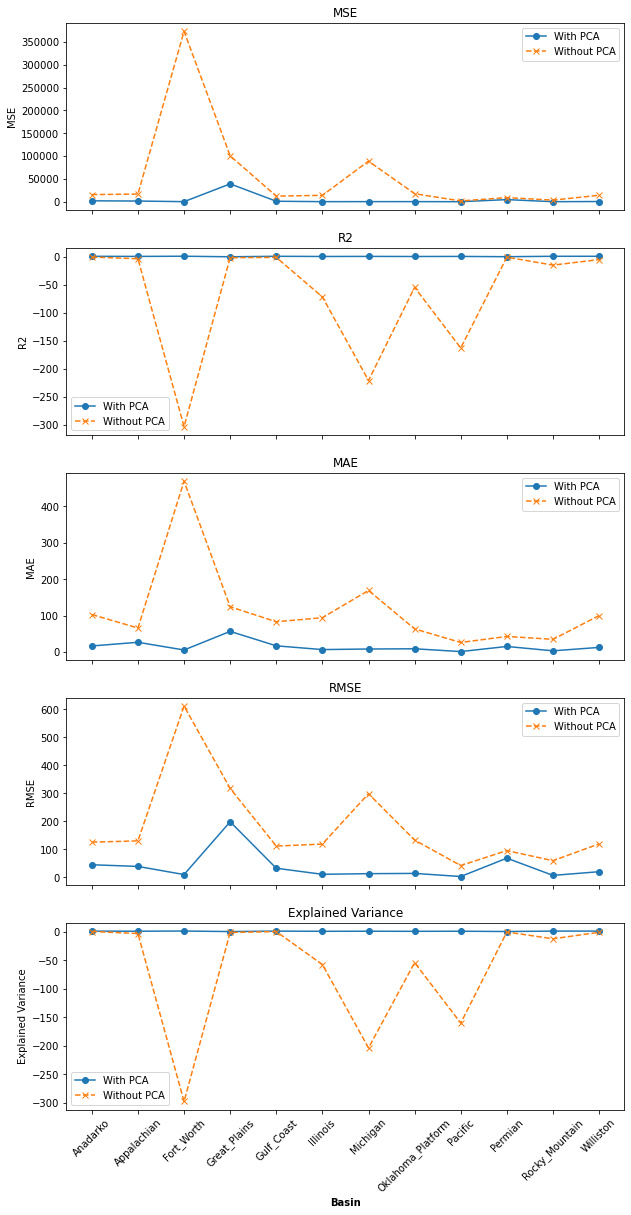

In [11]:
# Load results DataFrames
nn_results_df_with_pca = pd.read_csv("../../data/performance_comparison/neural_network_performance_pca.csv")
nn_results_df_without_pca = pd.read_csv("../../data/performance_comparison/neural_network_performance_no_pca.csv")

# Replace spaces with underscores in the basin names
nn_results_df_with_pca['Basin'] = nn_results_df_with_pca ['Basin'].str.replace(' ', '_')
nn_results_df_without_pca['Basin'] = nn_results_df_without_pca['Basin'].str.replace(' ', '_')

# Set 'Basin' as index now that the names are sanitized
nn_results_df_with_pca .set_index('Basin', inplace=True)
nn_results_df_without_pca.set_index('Basin', inplace=True)

# Merge the two results DataFrames
nn_combined_results = nn_results_df_with_pca.join(nn_results_df_without_pca, lsuffix='_with_pca', rsuffix='_without_pca')

# Define the metrics to compare
metrics = ['MSE', 'R2', 'MAE', 'RMSE', 'Explained Variance']

# Create a figure and axes for the subplots
fig, axs = plt.subplots(nrows=len(metrics), ncols=1, figsize=(10, 20), sharex=True)

# Plot comparisons for each metric
for idx, metric in enumerate(metrics):
    axs[idx].plot(nn_combined_results.index, nn_combined_results[metric + '_with_pca'], marker='o', label='With PCA', linestyle='-')
    axs[idx].plot(nn_combined_results.index, nn_combined_results[metric + '_without_pca'], marker='x', label='Without PCA', linestyle='--')
    
    axs[idx].set_ylabel(metric)
    axs[idx].set_title(metric)
    axs[idx].legend()

# Set common labels
plt.xlabel('Basin', fontweight='bold')
plt.xticks(rotation=45)
plt.savefig("../../images/performance_comparison_plots/neural_network_performance_comparison.png")